# Imports

In [4]:
import pandas as pd
import numpy as np
# Data Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale= 2)

import re
import string
import os
from tqdm import tqdm as tq
import time


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms, datasets, models
from PIL import Image

from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report

### Device

In [5]:
if torch.cuda.is_available():
    print(f"GPU:{torch.cuda.get_device_name()}")
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    print(DEVICE)

cpu


### Helper Methods

In [6]:

def remainig_time(tt):
    if tt/60 < 1:
        return "{} sec".format(int(tt))
    if tt/60/60 < 1:
        return "{} min".format(int(tt/60))
    if tt/60/60/24 < 1:
        mins = tt/60
        hrs = mins/60
        return "{:.2f} hrs".format(hrs)
    if tt/60/60/24 > 1:
        days = tt/60/60/24
        return "{:.2f} days".format(days)


def save_model(model, optim, loss_train, loss_val, acc_train, acc_val, epoch, model_name, model_path=''):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optim.state_dict(),
        'loss_train': loss_train,
        'loss_val': loss_val,
        'epoch': epoch,
        'acc_train': acc_train,
        'acc_val': acc_val,
    }, os.path.join(model_path, model_name))


def load_model(model_path, device=DEVICE):
    return torch.load(model_path, map_location=device)

### Constants

In [7]:
# Hyper Parameters (You can change as you like ... and see how it affects the results)
LR = 3e-5
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_RESIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 100
# Constants
NUM_WORKERS = 3 # Based on the 
NUM_CLASSES = 2
CLASSES = ['NORMAL', 'PNEUMONIA']
CHANNELS = 1
MIN_ACC = float('-inf')
# Data Path
DATA_PATH = 'C:/Users/20106/Desktop/Practical-DS-Session-main/Pneumonia/chest_xray/'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train/')
VAL_DATA_PATH = os.path.join(DATA_PATH, 'val/')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'test/')

## reading the data 

In [8]:
def reading(path):
    import glob as gb
    x=[]
    img_path=[]
    label=[]
    for folder in os.listdir(path ) :
        files = gb.glob(pathname= str(path + folder +'/*.jpeg'))
        x.append(files)
        print(f'For passed data , found {len(files)} in folder {folder}')
    normal=x[0]
    pneumonia =x[1]
    img_path=normal+pneumonia
    for i in img_path :
        if i in normal :
            label.append(0)
        else: 
            label.append(1) 
    return img_path,label


## indexing the data

In [9]:
def indexing(x):
    
    for i in x :
        if i in normal :
            label.append(0)
        else: 
            label.append(1)   
    return label

## get the data

In [10]:
def get(path):
    x,y=reading(path)
    print(len(x))
    X=pd.Series(x)
    Y=pd.Series(y)
    return X , Y

In [11]:
x1,y1=get(TRAIN_DATA_PATH)
x2,y2=get(TEST_DATA_PATH)
x3,y3=get(VAL_DATA_PATH)


For passed data , found 1341 in folder NORMAL
For passed data , found 3875 in folder PNEUMONIA
5216
For passed data , found 234 in folder NORMAL
For passed data , found 390 in folder PNEUMONIA
624
For passed data , found 8 in folder NORMAL
For passed data , found 8 in folder PNEUMONIA
16


## reding and training validation

In [12]:

df_train=pd.DataFrame(x1.append(x3),columns=['img_pass'])
df_train['label']=pd.DataFrame(y1.append(y3))
df_train.to_csv('train.csv')

In [13]:
df_test=pd.DataFrame(x2,columns=['img_pass'])
df_test['label']=pd.DataFrame(y2)
df_test.to_csv('test.csv')

### Create Your Pipeline of image transformation

In [14]:
# Transformation
TR = transforms.Compose(
[transforms.Grayscale(CHANNELS),

transforms.Resize(IMG_RESIZE)
,transforms.ToTensor(),
transforms.Normalize(mean=0.5,std=0.5)
])

### Dataset Preparation

In [15]:
trainset=datasets.ImageFolder(TRAIN_DATA_PATH,transform=TR)
print("Trainset Size:  {}".format(len(trainset)))

Trainset Size:  5216


In [16]:
validateset=datasets.ImageFolder(VAL_DATA_PATH,transform=TR)
print("validateset Size:  {}".format(len(validateset)))

validateset Size:  16


In [17]:
testset=datasets.ImageFolder(TEST_DATA_PATH,transform=TR)
print("testset Size:  {}".format(len(testset)))

testset Size:  624


In [18]:
trainloader = DataLoader(trainset,batch_size=64,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader)))
validationloader = DataLoader(validateset,batch_size=64,shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples:{}".format(len(validationloader.dataset)))
testloader = DataLoader(testset,batch_size=64,shuffle=True)
print("No. of batches in testloader:{}".format(len(testloader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples:{}".format(len(testloader.dataset)))


No. of batches in trainloader:82
No. of batches in validationloader:1
No. of Total examples:16
No. of batches in testloader:10
No. of Total examples:624


In [19]:
print(f"Images in Training set: {df_train.shape[0]:,}")
print(f"Images in Testing set: {df_test.shape[0]:,}")

Images in Training set: 5,232
Images in Testing set: 624


In [20]:
len(df_train.img_pass)

5232

In [21]:
print(df_train.iloc[2][0])

C:/Users/20106/Desktop/Practical-DS-Session-main/Pneumonia/chest_xray/train/NORMAL\IM-0119-0001.jpeg


In [22]:
df_train.sample(3)

,img_pass,label
1528,C:/Users/20106/Desktop/Practical-DS-Session-ma...,1
2524,C:/Users/20106/Desktop/Practical-DS-Session-ma...,1
1736,C:/Users/20106/Desktop/Practical-DS-Session-ma...,1


C:\Users\20106\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

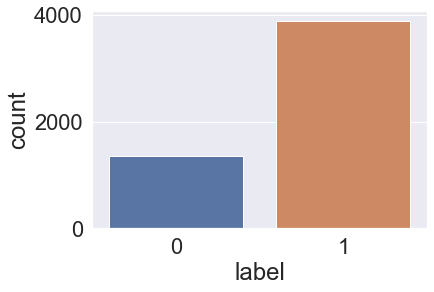

In [23]:
sns.countplot(df_train.label)

Now given this high bias in our dataset ... we will fix it using 2 tricks ...
  - weighted loss   
  
  so when our model **wrongly predict class 0** (the minority class) ... we **punish him more than** if he predicted class 1 wrong (the majority class)
  - Balance the Evaluation dataset  
  
  we make our evalution dataset has same number of **class 0 and class 1** ... in-order to make the right decision when model has high accuracy

### Weighted Loss

In [24]:
df_train.label.value_counts()

1    3883
0    1349
Name: label, dtype: int64

In [25]:
x=3883+1349
weight=torch.Tensor([3891,1341])/x
criterion = nn.NLLLoss(weight= weight).to(DEVICE)
print(criterion.weight)

tensor([0.7437, 0.2563])


In [26]:
class Dataset():
    from skimage import io
    import cv2
    def __init__(self, root_dir, transform=None):
        
        
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.root_dir)

    def __getitem__(self, index):
        img_path =self.root_dir.img_pass.iloc[index]
        image=Image.open(img_path).convert("RGB")
        image = cv2.imread(img_path)

        
        y_label=self.root_dir.label.iloc[index]
        #y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        image=self.transform(image)

        return {"image":image.shape, "label":y_label}

In [28]:
c=Dataset(df_train,TR)
from skimage import io
import cv2
c

In [29]:
train_loader = DataLoader(dataset=trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=64, shuffle=True)

In [30]:
class XrayClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 32, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            
            nn.Conv2d(32, 64, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64, 128, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.ReLU(),
            nn.Conv2d(128, 128, padding=1, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            
            nn.Flatten(),
            nn.Linear(128*15*21, 1024),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
    
    def forward(self, image):
        return self.model(image)

In [32]:
model=XrayClassifier()
model

XrayClassifier(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=40320, out_features=1024, bias=True)
    (18): Dropout(p=0

In [33]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
model = model.to(device)
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(validationloader, device)
test_dl = DeviceDataLoader(testloader ,device)


In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
CHANNELS = 1
BS = 1 # Batch Size
ex = torch.rand(BS, CHANNELS, IMG_WIDTH, IMG_HEIGHT)
model = XrayClassifier()
model.eval()
out = model(ex)
print(out.shape)
out

#### Training method

In [ ]:
def train_fn(batches, model, optim, scheduler, device=DEVICE):
    model.train() # set the model mode => training
    batch_acc = 0
    ep_loss = 0
    # Loop through the training batches
    for batch in tqdm(batches, total=len(batches), position=0, leave=True):
        
        imgs, labels = # Get Your image and targets from the given batch
        # Forward Propagation
        labels_pred = ## Get Your predictions from model
        # Calculate Loss
        loss = ## Get your loss bet. Predictions and Targets
        # Backward propagation (Check: https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944)
        ## - Zero your optimizer gradients
        ## - Calculate loss gradient
        ## - Make step with optimizer
        ## - Accumulating Loss & Accuracy Across batches
        ep_loss += loss.item()
        batch_acc += sum(labels == labels_pred.argmax(1)).item()
    # Calculate The whole Epoch Accuracy after the batches loop ends
    ep_acc = batch_acc / (BATCH_SIZE * len(batches))
    ## Return the ep_loss and the ep_acc
    return ep_loss, ep_acc

SyntaxError: invalid syntax (Temp/ipykernel_11028/876353295.py, line 8)

#### Evaluation method

In [ ]:
def eval_fn(batches, model, device=DEVICE):
    """
    Calculate the model accuracy & loss on given eval data ... no training is needed here
    just prediction and comparing results
    """
    ## Write your code here
    return ep_loss, ep_acc

#### Prediction method

In [ ]:
def pred_fn(batches, model, device=DEVICE):
    """
    Predict Test batches
    Args:
        batches (generator): Test Batches
        model (model object): Trained Model
        device (gpu/cpu device, optional): active device. Defaults to DEVICE.

    Returns:
        predictions: List of predictions
        true_labels: List of true labels
    """
    ## Write your code here
    return predictions, true_labels

### Dataset Class

{'image': (1144, 1450, 3), 'label': 0}

In [ ]:

            }

NameError: name 'Dataset' is not defined

### Model

NameError: name 'ClassificationModel' is not defined

'cpu'

##### Test your model with random input

AttributeError: 'XrayClassifier' object has no attribute 'conv1'

In [ ]:
k=datasets.ImageFolder(root=TRAIN_DATA_PATH)
k

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: C:/Users/20106/Desktop/Practical-DS-Session-main/Pneumonia/chest_xray/train/

### Split your Dataset

In [ ]:
from torch.utils.data import WeightedRandomSampler
sample_weights=[0]*len(df_train)
for inx,(data,label) in enumerate(len(df_train)):
    class_weight=riterion.weight[label]
    sample_weights[inx]=class_weight
sampler=WeightedRandomSampler(sample_weights, len(df_train))

train_imgs, val_imgs, train_labels, val_labels = train_test_split(df_train.img_pass,df_train.label,test_size=0.20,random_state=42)

print(f"{len(train_imgs):,} Training imgs")
print(f"{len(val_imgs):,} Validation imgs")

TypeError: 'int' object is not iterable

In [ ]:

train_imgs, val_imgs, train_labels, val_labels = ## Write your code here

print(f"{len(train_imgs):,} Training imgs")
print(f"{len(val_imgs):,} Validation imgs")

4,186 Training imgs
1,046 Validation imgs


### Check Validation labels ... should be equal

In [ ]:
val_labels.value_counts()

### Dataset instances for Train, Val & Test

In [ ]:
train_dataset = ## Write your code here
val_dataset = ## Write your code here
test_dataset = ## Write your code here

### Data-Loader

In [ ]:
train_batches = ## Write your code here
val_batches = ## Write your code here
test_batches = ## Write your code here

### Initialize your model, optimizer

In [ ]:
model

XrayClassifier()

In [ ]:
model =XrayClassifier(train_loader)
optim =  torch.optim.Adam(model.parameters(), lr=0.001)

TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
## Create History For saving your losses and accuracies
history= {}
history['train_loss'] = []
history['val_loss'] = []
history['train_acc'] = []
history['val_acc'] = []

### Training Loop

In [ ]:
for epoch in range(EPOCHS):
        s = time()
        # train
        ep_train_loss, ep_train_acc = train_fn(train_batches, model, optim, scheduler)
        # eval
        ep_val_loss, ep_val_acc = eval_fn(val_batches, model)
        e = time()

        epoch_t = remainig_time(e - s)
        whole_time = remainig_time((e - s) * (EPOCHS - epoch))
        print(f"\nEpoch:{epoch}/{EPOCHS}---Loss-train:{ep_train_loss:.4f}---Loss-Val: {ep_val_loss:.4f}---Acc-Train:{(ep_train_acc*100):.2f}%---Acc-Val: {(ep_val_acc*100):.2f}%---Acc-Test: {(ep_test_acc*100):.2f}---%epoch elapsed:{epoch_t}---Remaining:{whole_time}")
        
        ## Write your code here ## append the training loss
        ## Write your code here ## append the validation loss
        ## Write your code here ## append the training acc
        ## Write your code here ## append the validation acc

        if ep_val_acc > MIN_ACC:
            print("Saving Model ...")
            model_name = f'Xray_ep_{epoch}_acc_{(ep_test_acc*100):.3f}_.pth'
            MIN_ACC = ep_test_acc
            # Save Your model Checkpoint
            ## Write your code here

## Prediction

In [ ]:
MODEL_PATH = '' # Get your model path
checkpoint = load_model(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict']) # Just loading the model weights

In [ ]:
preds, labels = pred_fn(test_batches, model)

In [ ]:
print(f"Accuracy: {(np.array(preds) == np.array(labels)).mean()*100:.1f}% On Test Set")

In [ ]:
print(classification_report(labels, preds, target_names=CLASSES))

### Create a confusion matrix and plot it

In [ ]:
## Write your code here

# Great Work ... 💪💪

Now you're able to get and start applying your various types of ***DL approches*** and ***compete with many Kagglers***
There exist huge amount of images data out there ... that you're now able to give it a try and apply your own model on ... Good Start 👍👍😊